<a href="https://colab.research.google.com/github/giorginolab/MD-Tutorial-Data/blob/main/notebooks/2b_MDTraj_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MD analysis: Gelsolin WT/mutant, apo/nanobody example 
*Toni Giorgino, IBF-CNR, Italy* - www.giorginolab.it

This is a Python notebook, based on Google Colaboratory platform. For an introduction to the platform, see [here](https://colab.research.google.com/notebooks/welcome.ipynb). You will be able to edit Python statements on this notebook by entering them into "cells", and execute them with the "play" button.

Notes:
 * The order of execution matters, not the order of display. 
 * To start from scratch, restart the runtime. 
 * Shell commands: prefix with an ! symbol.  E.g. `!ls -l` lists the contents of the current directory.
 * If you don't have a Google account, you may copy-paste the  statements in  local Python installations.
 * To plot, see examples [here](https://colab.research.google.com/notebooks/charts.ipynb).

The class is based on the following paper:

> Giorgino T, Analysis libraries for molecular trajectories: a cross-language synopsis. Chapter 20 in:  Biomolecular Simulations: Methods and Protocols Edited by M. Bonomi and C. Camilloni (Springer, ISBN 978-1-4939-9608-7).  [Preprint here](https://github.com/giorginolab/preprints-repository/tree/master/analysis_libraries_chapter)

and on the biological example from:

> Giorgino T, Mattioni D, Hassan A, Milani M, Mastrangelo E, Barbiroli A, et al. Nanobody interaction unveils structure, dynamics and proteotoxicity of the Finnish-type amyloidogenic gelsolin variant. Biochimica et Biophysica Acta (BBA) - Molecular Basis of Disease. 2019 Mar 1;1865(3):648–60. [Journal version](https://www.sciencedirect.com/science/article/pii/S0925443919300109?via%3Dihub). [Preprint here](https://arxiv.org/abs/1903.07308).





# Retrieve simulation trajectories

This copies data on the server which is running the calculations (not your computer). See below to download files to your PC.

In [ ]:
%pwd

In [ ]:
# Get the data files if not there yet
! [ -f MD-Tutorial-Data ] || git clone https://github.com/giorginolab/MD-Tutorial-Data.git

In [ ]:
%ls -l MD-Tutorial-Data/GSN

# Download results to your PC

To download any file (not necessary, but may be useful to inspect results), use the little "folder" icon on the left.

# Install Python libraries

Should be done via either pip or conda. We may already have them.

In [ ]:
%pip install mdtraj
# %pip install mdanalysis
# %pip install moleculekit



## Analysis starts here

We will make use of Python (and its Numpy library) functions to answer a series of questions. 

Rewriting them in one of the other libraries and languages may be an useful exercise.

In [ ]:
import mdtraj as mdt
# import MDAnalysis as mda
# import moleculekit as mk
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# The file set we plan to analyze. In this case it may be WT, WT+Nb, 
# D187N, D187N+Nb .

pdb="MD-Tutorial-Data/GSN/WT+Nb-run.pdb"
xtc="MD-Tutorial-Data/GSN/WT+Nb-run-subset.xtc"

# psf="WT+Nb-run.psf"  # but we don't use this one


In [ ]:
m=mdt.load(xtc, top=pdb)

In [ ]:
m

# Exercises

Write code to answer the following questions

## Residues?

How is it possible that there are so many "residues"?

## How many chains are there? 

Note that these are simulation structures, and may use chains for different purposes than crystallographic structures. We extract actual chain information from each atom's property. [Note:  MDAnalysis has another classification called "Segments", which mostly, but not entirely, overlaps chains.]

In [ ]:
#@title Answer... {display-mode: "form"}

m.n_chains


## How many residues and atoms per each chain?

Hint: use

    for c in m.topology.chains:
        # do something with c

In [ ]:
#@title Solution... {display-mode: "form"}
 
for c in m.topology.chains:
    print(f"Chain {c} has {c.n_residues} residue, {c.n_atoms} atoms")  # QUESTION

## How many Cα atoms?

In [ ]:
# Write your answer here


In [ ]:
#@title Solution... {display-mode: "form"}
len(list(m.topology.select("name CA")))

## Is your structure solvated? If so, remove solvent.

In [ ]:
non_h2o = m.topology.select("not water")
len(list(non_h2o))

# ..... 


In [ ]:
#@title Solution... {display-mode: "form"}

m_nowater=m.atom_slice(non_h2o) #QUESTION

In [ ]:
m_nowater.n_atoms

## How many frames? How many nanoseconds?

In [ ]:
#@title Solution... {display-mode: "form"}
m_nowater.n_frames          #QUESTION

## Count how many species of ions and how many of each

In [ ]:
resnames = np.unique([r.name for r in m.topology.residues])
print(resnames)

Hint: use the following

`for ion in ["CAL","CLA","SOD"]:`

In [ ]:
#@title Solution... {display-mode: "form"}
for ion in ["CAL","CLA","SOD"]:
    ions = [a.index for a in m_nowater.topology.atoms if a.residue.name == ion]    #QUESTION
    print(f"There are {len(ions)} atoms of type {ion}")



## Align to the G2's first frame

Now keep only chain D (chainid 3) and align to its frame 0. For atom selections, refer to https://www.mdtraj.org/1.9.8.dev0/atom_selection.html .

In [ ]:
#@title Solution... {display-mode: "form"}
cD = m.topology.select("protein and chainid 3")           #QUESTION
mD = m.atom_slice(cD)                                     #QUESTION

In [ ]:
align_idx = mD.topology.select("name CA and resid < 240")
mD.superpose(mD, 0, align_idx)

# In case you want to inspect
mD.save("check.pdb")
mD.save("check.xtc")

In [ ]:
!ls -l

## Inspect the shape of the coordinates. 

MDTraj uses frames x atoms x 3

In [ ]:
mD.xyz.shape

## Compute backbone global RMSD(t) 

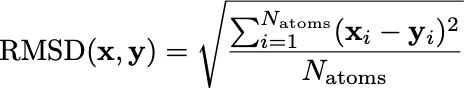

In [ ]:
T = mD.n_frames
N = mD.n_atoms # CA only: 1 atom = 1 residue

rmsdT = np.zeros((T))
X = mD.xyz[0,:,:]  # First frame, all axes, all atoms

for t in range(T):
  Y = mD.xyz[t,:,:]  # Frame at t, all axes, all atoms
  d2 = (X-Y)**2   # This is still a matrix
  sd2 = np.sum(d2)/N
  rmsdT[t]=np.sqrt(sd2)

print(rmsdT)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(T), rmsdT)
plt.xlabel("Simulation time (10*ns)")
plt.ylabel("Cα RMSD (Å)")

## Compute displacements *by residue and time*.

In [ ]:
rmsdRT = np.zeros((T,N))

for i in range(N):
  Xi = mD.xyz[0,i,:] # First frame, all axes, atom i
  for t in range(T):
    Yi = mD.xyz[t,i,:]  # Time t, atom i, 3D vector
    dist = np.sum((Xi-Yi)**2)   # Displacement^2
    rmsdRT[t,i]=np.sqrt(dist)

print(rmsdRT)

In [ ]:
rmsdRT.shape

In [ ]:
plt.figure(figsize=(10,5))
plt.imshow(rmsdRT.T, aspect="auto", cmap="binary")
plt.ylabel("Residue")
plt.xlabel("Time (ns/10)")

## Question

How to modify the code so that the vertical axis is *actually* residues?

**Hint:** No need to compute for all atoms of a residue.

## Average over time

In [ ]:
plt.figure(figsize=(10,5))
rmsdR = np.mean(rmsdRT,axis = 0) # <-- note: mean over axis 0, which is time
plt.plot(np.arange(N), rmsdR)
plt.xlabel("Residue")
plt.ylabel("Mean displacement (A)")